# _Decision trees_

Patroonherkenning in gestructureerde (en in bepaalde gevallen ook semi-gestructureerde) data is vaak zeer succesvol met zogenaamde _decision tree_ modellen, of althans moderne varianten daarvan.

## Model
Het model bestaat uit een **beslissingsboom**. **Iedere vertakking staat voor een bepaalde feature die opgesplitst wordt**.

:::{note} 🌍
:icon: false
:class: simple 
We illustreren dit aan de hand van de bekende [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set).
  
De data is afkomstig van drie varianten van Irisbloemen:
1. Iris setosa (_target feature: 0_) 
2. Iris versicolor (_target feature: 1_) 
3. Iris virginica (_target feature: 2_)  
  
Voor elke soort werden 50 observaties gemaakt van vier continue features: 
1. Sepal length (cm) (_feature kolom: 0_)
2. Sepal width (cm) (_feature kolom: 1_)
3. Petal length (cm) (_feature kolom: 2_)
4. Petal width (cm) (_feature kolom: 3_) 
  
![](https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Petal-sepal.jpg/250px-Petal-sepal.jpg)
:::

In [1]:
import dtreeviz
import matplotlib
import pandas as pd
from sklearn import tree
from sklearn.datasets import load_iris

from ml_courses.utils import display_dtreeviz

matplotlib.set_loglevel("ERROR")

In [2]:
iris = load_iris()
X, y = iris.data, iris.target
clf = tree.DecisionTreeClassifier(random_state=123)
clf = clf.fit(X, y)

In [3]:
viz_model = dtreeviz.model(
    clf,
    X_train=X,
    y_train=y,
    feature_names=iris.feature_names,
    target_name="Iris type",
    class_names=iris.target_names,
)

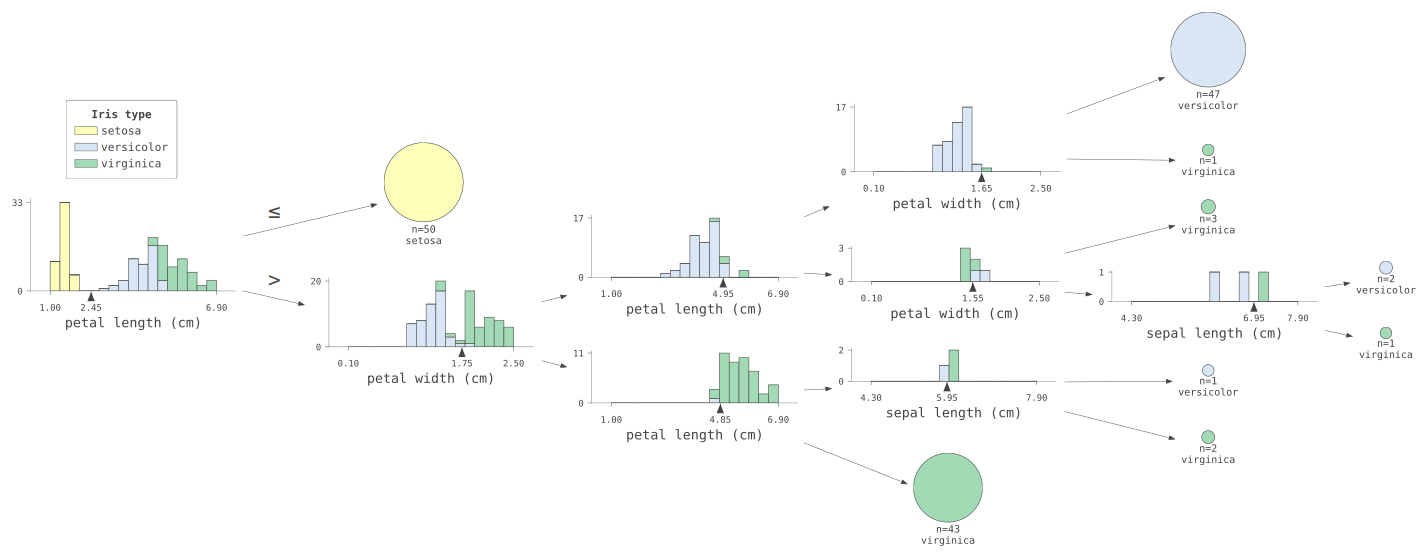

In [4]:
display_dtreeviz(viz_model.view(orientation="LR", fontname="DejaVu Sans Mono", scale=1.5))

:::{note} 🌍
:icon: false
:class: simple
We moeten de boomstructuur als volgt "lezen":
  
```python
if petal_length <= 2.45:
    return "Setosa"
else:
    if petal_width <= 1.75:
        if petal_length <= 4.95:
            if petal_width <= 1.65:
                return "Versicolor"
            else:
                return "Virginica"
        else:
            if petal_width <= 1.55:
                return "Virginica"
            else:
                if sepal_length <= 6.95:
                    return "Versicolor"
                else:
                    return "Virginica"
    else:
        if petal_length <= 4.85:
            if sepal_length <= 5.95:
                return "Versicolor"
            else:
                return "Virginica"
        else:
            return "Virginica"
:::

## Parameters
**De volledige conditionele structuur, zoals hierboven geïllustreerd, vormt de parameters van het model. We weten met andere woorden niet op voorhand met hoeveel parameters we zullen eindigen - of hoe complex het model uiteindelijk zal zijn**. Dat heeft het voordeel dat we een heel flexibel model hebben, maar het nadeel dat we goed moeten opletten voor over-complexiteit en over-fitting. Er zijn wel verschillende hyper parameters zoals de maximum diepte van de vertakkingen, het minimum aantal voorbeelden in een vertakking, enz, maar dat verandert niets aan het feit dat we de model complexiteit niet rechstreeks in de hand hebben.

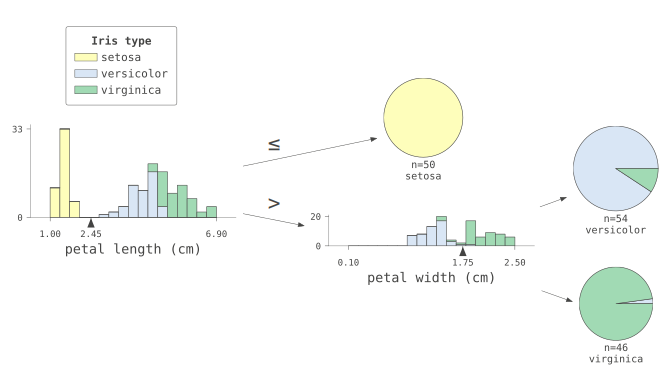

In [5]:
clf2 = tree.DecisionTreeClassifier(max_depth=2, random_state=123)
clf2 = clf2.fit(X, y)

viz_model2 = dtreeviz.model(
    clf2,
    X_train=X,
    y_train=y,
    feature_names=iris.feature_names,
    target_name="Iris type",
    class_names=iris.target_names,
)

display_dtreeviz(viz_model2.view(orientation="LR", fontname="DejaVu Sans Mono", scale=1.5))

## Features
_Decision trees_ kunnen algemeen gesproken flexibel om met veel en heterogene features. Ze hebben ook een natuurlijke manier om features met een hoge en lage discriminatieve waarde te onderscheiden. **_Distinctive features_** zijn features met een hoge discriminatieve waarde; hun waarden correleren heel sterk met de target waarden.

:::{note} 🌍
:icon: false
:class: simple
`Petal length` heeft een hoge _distinctive value_ met betrekking tot het onderscheid `Setosa` versus `{Versicolor, Virginica}`
:::

Op iedere niveau worden alle features in overweging genomen, maar enkel de meest _informatieve_ wordt gebruikt. Daardoor komen minder informatieve features automatisch naar diepere vertakkingen geduwd en worden niet-informatieve features automatisch geweerd uit het model. Er dus een impliciete feature selectie.
  
Doordat feature-schalen simpelweg opgedeeld worden binnen de boomstructuur, zijn _decision trees_ ook heel geschikt om niet-lineaire verbanden te herkennen - zonder dat er veel _feature engineering_ aan te pas moet komen.
  
Tenslotte kunnen _decision trees_ ook vrij gemakkelijk omgaan met _missing values_. De vaakst gebruikte strategie zijn _surrogate splits_. Hierbij wordt voor iedere vertakkingsconditie (bv. `petal_length <= 2.45`) een back-up regel of back-up regels voorzien.

In [6]:
# Get feature importance scores
feature_importance = clf.feature_importances_
for name, importance in zip(iris.feature_names, feature_importance, strict=False):
    print(f"{name}: {importance:.3f}")

sepal length (cm): 0.027
sepal width (cm): 0.000
petal length (cm): 0.551
petal width (cm): 0.423


## Optimalisatie
Om de optimale vertakkingen te vinden wordt **sequentieel gezocht naar de best mogelijke _split_ op een van de features**. Er worden bij iedere stap volgens bepaalde (deels random) principes een reeks kandidaat _splits_ opgemaakt. Die kandidaten worden geëvalueerd met betrekking tot de kwaliteit van de predicties op het volgende niveau. Er is geen algemene _loss_-functie, maar wel op het niveau van individuele splits. In veel tekstboeken wordt niet over een _loss_-functie gesproken in de context van _decision trees_, maar er is wel degelijk sprake van een evaluatie van (sub)optimaliteit tijdens het trainen.
  
In de context van klassificatie wordt er bij iedere _split_ gekeken naar de _impurity_: hoe zuiver zijn de data met betrekking tot de target categorieën? _Gini impurity_ en _Entropy_ zijn de meest voorkomende maten. Beiden komen in detail aan bod in de cursus Mathematical Foundations. In het geval van regressie is het de bedoeling dat een _split_ tot een betere predictie leidt in de vertakkingen. Er wordt in plaats van _impurity_ naar de _Mean Squared_ of _Absolute Error (MSE/MAE)_ gekeken. 

## Taken, Ervaring, Performantie
Naast **klassificatie** kunnen _decision trees_ ook voor **regressie** gebruikt worden. In beide gevallen gaat het om **supervised** learning.


:::{note} 🌍
:icon: false
:class: simple
Om regressie met _decision trees_ te illustreren kijken we naar een dataset waarbij we het verbruik (_Miles Per Gallon_) trachten te voorspellen aan de hand van het aantal cilinders, cilinderinhoud en gewicht.
:::

In [7]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/cars.csv"
df = pd.read_csv(dataset_url)
X = df.drop("MPG", axis=1)
y = df["MPG"]
features = list(X.columns)

In [8]:
reg = tree.DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
reg.fit(X.values, y.values)

viz_rmodel = dtreeviz.model(reg, X, y, feature_names=features, target_name="MPG")

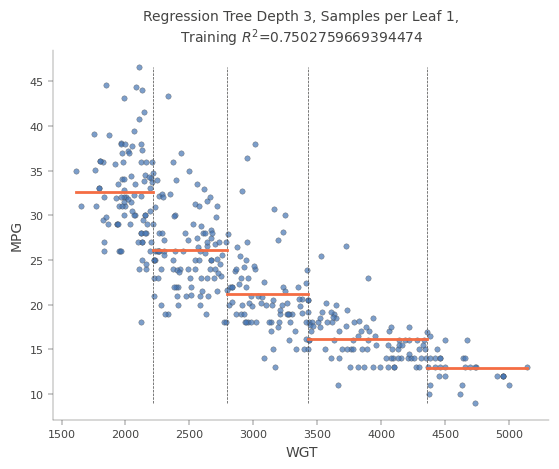

In [9]:
viz_rmodel.rtree_feature_space(features=["WGT"])

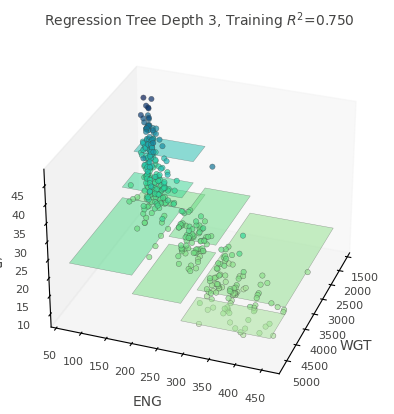

In [10]:
viz_rmodel.rtree_feature_space3D(
    features=["WGT", "ENG"],
    fontsize=10,
    elev=30,
    azim=20,
    show={"splits", "title"},
    colors={"tessellation_alpha": 0.5},
)

Om de performantie van _decision trees_ te evalueren wordt in de eerste plaats gekeken naar de metrieken die ook de training sturen (_Gini impurity/Entropy/Misclassification rate/MSE/MAR_).
Omdat er een reëel gevaar bestaat voor _overfitting_ wordt veel belang gehecht aan de performantie bij ongeziene test data.

## Voordelen
- Interpreteerbaarheid: Iedere vertakking heeft een duidelijke betekenis
- Flexibiliteit (oa. ook geschikt voor multi-output problemen)
- Computationele efficiëntie omdat er geen globale optimalisatie gebeurt (_greedy_ optimisatie)

## Nadelen
- _Greedy_ optimalisatie geeft geen garantie op een globaal optimale boomstructuur
- Onstabiliteit: kleine aanpassingen aan de data kunnen een groot verschil geven in de boomstructuur
- Moeite met lineaire relaties: hoewel ze heel goed om kunnen met niet-lineariteit, moeten ze (te) veel splits maken om een lineair verband te leren
- Moeite met extrapolatie: ze kunnen enkel splits en predicties maken in de range van de trainingsdata 
- **Overfitting**: het aantal parameters kan ongecontroleerd groeien waardoor er overfitting optreedt